###                     -------------------------- Multi-task learning -------------------------------       

In [31]:
import os
import torch
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra

print(os.listdir("MAFood121"))

['annotations', 'images']


In [2]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
torch.manual_seed(42) # try and make the results more reproducible
BASE_PATH = 'MAFood121/'

In [3]:
epochs = 35
batch_size = 64
MICRO_DATA = True # very small subset (just 3 groups)
SAMPLE_TRAINING = False # make train set smaller for faster iteration
IMG_SIZE = (384, 384) # Try to change the model to U-net to avoid the resizing


In [4]:
#Classes of dishes
f = open(BASE_PATH + '/annotations/dishes.txt', "r")
classes = f.read().strip().split('\n')
f.close()
print("***** classes = dishes.txt: ***** " + str(classes))
print("#######################################################################################")

#Ingredients for each class
f = open(BASE_PATH + '/annotations/foodgroups.txt', "r")
ingredients = list(set(f.read().strip().split('\n')))
f.close()
print("***** ingredients = foodgroups.txt: ***** " + str(ingredients))
print("#######################################################################################")

#Base Ingredients
f = open(BASE_PATH + '/annotations/baseIngredients.txt', "r")
base_ing = f.read().strip().split(', ')
f.close()
print("***** base_ing = baseIngredients.txt: ***** " + str(base_ing))
print("#######################################################################################")


***** classes = dishes.txt: ***** ['d_artichoke_bottoms_in_olive_oil', 'd_baby_back_ribs', 'd_banh_mi', 'd_banh_xeo', 'd_beef_bourguignon', 'd_beef_carpaccio', 'd_beef_in_oyster_sauce', 'd_biryani', 'd_blanquette_de_veau', 'd_borek', 'd_breakfast_burrito', 'd_bruschetta', 'd_bun_cha', 'd_butter_chicken', 'd_caesar_salad', 'd_cao_lau', 'd_caprese_salad', 'd_cha_ca', 'd_charcoal-boiled_pork_neck', 'd_chicken_quesadilla', 'd_chilaquiles', 'd_chiles_en_nogada', 'd_chole', 'd_chow_mein', 'd_cig_kofte', 'd_clam_chowder', 'd_club_sandwich', 'd_coconut_milk-flavored_crepes_with_shrimp_and_beef', 'd_coconut_milk_soup', 'd_com_tam', 'd_confit_de_canard', 'd_coq_au_vin', 'd_croque_madame', 'd_eggs_benedict', 'd_enchiladas', 'd_foie_gras', 'd_french_onion_soup', 'd_fried_mussel_pancakes', 'd_fried_pork_in_scoop', 'd_gnocchi', 'd_goya_champuru', 'd_greek_salad', 'd_green_curry', 'd_guacamole', 'd_gyro', 'd_hamburger', 'd_hamsi', 'd_hot_and_sour_fish_and_vegetable_ragout', 'd_hot_and_sour_soup', 'd_

In [5]:
#Recovery of annotations ML
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

In [6]:
#train
f = open(BASE_PATH + '/annotations/train.txt', "r")
train_images = f.read().split('\n')
f.close()
f = open(BASE_PATH + '/annotations/train_lbls_ff.txt', "r")
train_labels = f.read().split('\n')
f.close()

#val
f = open(BASE_PATH + '/annotations/val.txt', "r")
val_images = f.read().split('\n')
f.close()
f = open(BASE_PATH + '/annotations/val_lbls_ff.txt', "r")
val_labels = f.read().split('\n')
f.close()

#test
f = open(BASE_PATH + '/annotations/test.txt', "r")
test_images = f.read().split('\n')
f.close()
f = open(BASE_PATH + '/annotations/test_lbls_ff.txt', "r")
test_labels = f.read().split('\n')
f.close()

In [7]:
#Recovery of annotations
#train
f = open(BASE_PATH + '/annotations/train.txt', "r")
train_imagessl = f.read().split('\n')
f.close()
f = open(BASE_PATH + '/annotations/train_lbls_d.txt', "r")
train_labelssl = f.read().split('\n')
f.close()

#val
f = open(BASE_PATH + '/annotations/val.txt', "r")
val_imagessl = f.read().split('\n')
f.close()
f = open(BASE_PATH + '/annotations/val_lbls_d.txt', "r")
val_labelssl = f.read().split('\n')
f.close()

#test
f = open(BASE_PATH + '/annotations/test.txt', "r")
test_imagessl = f.read().split('\n')
f.close()
f = open(BASE_PATH + '/annotations/test_lbls_d.txt', "r")
test_labelssl = f.read().split('\n')
f.close()

In [8]:
# Single-Label
train_images_sl = ["MAFood121/images/" + s for s in train_imagessl]
train_df_sl = pd.DataFrame({'path': train_images_sl, 'sl_class_id': train_labelssl})

val_images_sl = ["MAFood121/images/" + s for s in val_imagessl]
val_df_sl = pd.DataFrame({'path': val_images_sl, 'sl_class_id': val_labelssl})

test_images_sl = ["MAFood121/images/" + s for s in test_imagessl]
test_df_sl = pd.DataFrame({'path': test_images_sl, 'sl_class_id': test_labelssl})


In [9]:
# Multi-label
train_images_ml = ["MAFood121/images/" + s for s in train_images]
train_df_ml = pd.DataFrame({'path': train_images_ml, 'ml_class_id': train_labels})

val_images_ml = ["MAFood121/images/" + s for s in val_images]
val_df_ml = pd.DataFrame({'path': val_images_ml, 'ml_class_id': val_labels})

test_images_ml = ["MAFood121/images/" + s for s in test_images]
test_df_ml = pd.DataFrame({'path': test_images_ml, 'ml_class_id': test_labels})


In [10]:
#Dataframe for train images
import glob

train_ingredients = []
train_classid = []

# busca ambos archivos en el directorio de anotaciones
for file_path in glob.glob(BASE_PATH + '/annotations/train_lbls_*.txt'):
    with open(file_path) as f1:
        for line in f1:
            idx_ingredients = []
            classid = int(line)
            train_classid.append(classid)
            for ing in ingredients[classid].strip().split(","):
                idx_ingredients.append(str(base_ing.index(ing)))
            train_ingredients.append(idx_ingredients)

df_train = pd.DataFrame(mlb.fit_transform(train_ingredients), columns=mlb.classes_) #binary encode ingredients
df_train["path"] = train_df_ml['path'] #train_img_df['path']
df_train["ml_class_id"] = train_classid 
food_dict_train = df_train

new_data = []
for index, row in train_df_ml.iterrows():
    #food = row["class_name"]
    path = row["path"]
    class_id = row["ml_class_id"]
    
    binary_encod = food_dict_train.loc[food_dict_train["path"] == path]
    new_data.append(np.array(binary_encod)[0])

col_names = list(binary_encod.columns.values)
train_df = pd.DataFrame(new_data, columns = col_names)

In [11]:
#Dataframe for val images
val_ingredients = []
val_classid = []

# busca ambos archivos en el directorio de anotaciones
for file_path in glob.glob(BASE_PATH + '/annotations/val_lbls_*.txt'):
    with open(file_path) as f1:
        for line in f1:
            idx_ingredients = []
            classid = int(line)
            val_classid.append(classid)
            for ing in ingredients[classid].strip().split(","):
                idx_ingredients.append(str(base_ing.index(ing)))
            val_ingredients.append(idx_ingredients)

df_val = pd.DataFrame(mlb.fit_transform(val_ingredients), columns=mlb.classes_) #binary encode ingredients
df_val["path"] = val_df_ml['path']
df_val["ml_class_id"] = val_classid 
food_dict_val = df_val


new_data = []
for index, row in val_df_ml.iterrows():
    #food = row["class_name"]
    path = row["path"]
    class_id = row["ml_class_id"]
    
    binary_encod = food_dict_val.loc[food_dict_val["path"] == path]
    new_data.append(np.array(binary_encod)[0])

col_names = list(binary_encod.columns.values)
val_df = pd.DataFrame(new_data, columns = col_names)

In [12]:
#Dataframe for test images
test_ingredients = []
test_classid = []

# busca ambos archivos en el directorio de anotaciones
for file_path in glob.glob(BASE_PATH + '/annotations/test_lbls_*.txt'):
    with open(file_path) as f1:
        for line in f1:
            idx_ingredients = []
            classid = int(line)
            test_classid.append(classid)
            for ing in ingredients[classid].strip().split(","):
                idx_ingredients.append(str(base_ing.index(ing)))
            test_ingredients.append(idx_ingredients)

df_test = pd.DataFrame(mlb.fit_transform(test_ingredients), columns=mlb.classes_) #binary encode ingredients
df_test["path"] = test_df_ml['path']
df_test["ml_class_id"] = test_classid 
food_dict_test = df_test


new_data = []
for index, row in test_df_ml.iterrows():
    #food = row["class_name"]
    path = row["path"]
    class_id = row["ml_class_id"]
    
    binary_encod = food_dict_test.loc[food_dict_test["path"] == path]
    new_data.append(np.array(binary_encod)[0])

col_names = list(binary_encod.columns.values)
test_df = pd.DataFrame(new_data, columns = col_names)

In [13]:
train_df = train_df.merge(train_df_sl, left_on='path', right_on='path')
val_df = train_df.merge(val_df_sl, left_on='path', right_on='path') 
test_df = train_df.merge(val_df_sl, left_on='path', right_on='path')

In [14]:
train_df.to_hdf('train_df.h5','df',mode='w',format='table',data_columns=True)
val_df.to_hdf('val_df.h5','df',mode='w',format='table',data_columns=True)
test_df.to_hdf('test_df.h5','df',mode='w',format='table',data_columns=True)

C:\Users\danie\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
C:\Users\danie\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
C:\Users\danie\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
C

###                           --------------------------Segunda parte-------------------------------

In [16]:
#import torch
#import pandas as pd
from torch.utils.data import DataLoader, Dataset
import cv2
from tqdm import tqdm
from torchvision import transforms
#import numpy as np

In [17]:
# Load data from .h5 files
train_df = pd.read_hdf('train_df.h5', 'df')
val_df = pd.read_hdf('val_df.h5', 'df')
test_df = pd.read_hdf('test_df.h5', 'df')

In [18]:
epochs = 8
batch_size = 16
SMALL_DATA = False
IMG_SIZE = (224, 224)

if SMALL_DATA:
    train_df = train_df[:128]
    val_df = test_df[:128]
    test_df = test_df[:128]

col_names = list(train_df.columns.values)

ing_names = col_names[:-3]
targets = ing_names

In [19]:
class CustomDataset(Dataset):
    def __init__(target, df):
        target.df = df

    def __len__(target):
        return len(target.df)

    def __getitem__(target, idx):
        #print(target.df.iloc[idx])
        image_path = target.df.iloc[idx]['path']
        image = cv2.imread(image_path, 1)
        x = cv2.resize(image, IMG_SIZE)
        x = (torch.from_numpy(x.transpose(2,0,1))).float()
        sl_class_id = int(target.df.iloc[idx]['sl_class_id'])
        sl_onehot = np.array(sl_class_id)
        sl_onehot = (np.arange(len(classes)) == sl_onehot).astype(np.float32)
        sl_y = torch.from_numpy(sl_onehot)
        ml_y = []
        for i in range(len(base_ing)): # total food family
            ml_y.append(target.df.iloc[idx][str(i)])
        ml_y = np.array(ml_y, dtype=np.float32)
        #print(image_path, sl_y, ml_y)
        return (x, sl_y, ml_y)

In [20]:
# Define batch size
batch_size = 32

In [21]:
# Create DataLoader objects for training, validation, and testing sets
train_dataset = CustomDataset(train_df)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CustomDataset(val_df)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

test_dataset = CustomDataset(test_df)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [22]:
# ResNet50 Model
from torchvision import models
from torch import nn
from torchsummary import summary

resnet = models.resnet50(pretrained=True)
# Disable grad for all conv layers
for param in resnet.parameters():
    param.requires_grad = False

# Add two heads
resnet.last_linear = resnet.fc
n_features = resnet.fc.out_features
head_sl = nn.Sequential(
    nn.Linear(n_features, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.2),
    nn.Linear(512, len(classes))
)
head_ml = nn.Sequential(
    nn.Linear(n_features, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.2),
    nn.Linear(512, len(base_ing)),
    nn.Sigmoid()
)  

C:\Users\danie\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\danie\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
# Connect two heads
class FoodModel(nn.Module):
    def __init__(target, base_model, head_sl, head_ml):
        super().__init__()
        target.base_model = base_model
        target.head_sl = head_sl
        target.head_ml = head_ml

    def forward(target, x):
        x = target.base_model(x)
        sl = target.head_sl(x)
        ml = target.head_ml(x)
        return sl, ml

model = FoodModel(resnet, head_sl, head_ml)
#summary(model, (3, 224, 224))
model.to(device)

FoodModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

In [24]:
# Define Loss
sl_loss_fn = nn.CrossEntropyLoss()
ml_loss_fn = nn.BCELoss()

# Define Optimizer
optimizer = torch.optim.Adam(model.parameters())

In [25]:
"""
# Define function to calculate loss and train model
def train_step(model, optimizer, sl_loss_fn, ml_loss_fn, data, device):
    # Retrieve data
    x, sl_y, ml_y = data
    # Convert to device
    x = x.to(device)
    sl_y = sl_y.to(device)
    ml_y = ml_y.to(device)
    # Zero out gradients
    optimizer.zero_grad()
    # Forward pass
    sl_preds, ml_preds = model(x)
    # Calculate losses
    sl_loss = sl_loss_fn(sl_preds, sl_y)
    ml_loss = ml_loss_fn(ml_preds, ml_y)
    loss = sl_loss + ml_loss
    # Backward pass
    loss.backward()
    # Step optimizer
    optimizer.step()
    # Return losses
    return sl_loss.item(), ml_loss.item()

"""
#F1-----------------------------------------------------------------------------------------------------------
from sklearn.metrics import f1_score

def train_step(model, optimizer, sl_loss_fn, ml_loss_fn, data, device):
    # Retrieve data
    x, sl_y, ml_y = data

    # Convert to device
    x = x.to(device)
    sl_y = sl_y.to(device)
    ml_y = ml_y.to(device)

    # Zero out gradients
    optimizer.zero_grad()

    # Forward pass
    sl_preds, ml_preds = model(x)

    # Calculate losses
    sl_loss = sl_loss_fn(sl_preds, sl_y)
    ml_loss = ml_loss_fn(ml_preds, ml_y)
    loss = sl_loss + ml_loss

    # Calculate F1 score
    sl_f1 = f1_score(torch.argmax(sl_y, axis=1).cpu().numpy(), torch.argmax(sl_preds, axis=1).cpu().numpy(), average='macro')
    ml_f1 = f1_score(torch.argmax(ml_y, axis=1).cpu().numpy(), torch.argmax(ml_preds, axis=1).cpu().numpy(), average='macro')
    
    #ml_f1 = f1_score(ml_y.cpu().numpy(), (ml_preds > 0.5).cpu().numpy(), average='macro')

    # Backward pass
    loss.backward()

    # Step optimizer
    optimizer.step()

    # Return losses and F1 scores
    return sl_loss.item(), ml_loss.item(), sl_f1, ml_f1

epochs= 100
for i in tqdm(range(epochs), desc='Epochs'):
    print("Epoch ",i)
    with tqdm(train_loader, desc='Training', total=len(train_loader), miniters=1) as pbar:
        #print(pbar)
        for data in pbar: 
            SL_loss, ML_loss, SL_f1, ML_f1 = train_step(model, optimizer, sl_loss_fn, ml_loss_fn, data, device)
            print(" ----- Single Label -----")
            print(" Loss : ", SL_loss , "     F1-score : ", SL_f1)
            print(" ----- Multi Label -----")
            print(" Loss : ", ML_loss , "     F1-score : ", ML_f1)
            break

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch  0



Epochs:   1%|          | 1/100 [00:05<08:31,  5.17s/it]

 ----- Single Label -----
 Loss :  4.929662704467773      F1-score :  0.0
 ----- Multi Label -----
 Loss :  0.7509181499481201      F1-score :  0.15531015037593987
Epoch  1



Epochs:   2%|▏         | 2/100 [00:05<03:51,  2.36s/it]

 ----- Single Label -----
 Loss :  4.897595405578613      F1-score :  0.0
 ----- Multi Label -----
 Loss :  0.6266269683837891      F1-score :  0.015873015873015876
Epoch  2



Epochs:   3%|▎         | 3/100 [00:05<02:20,  1.44s/it]

 ----- Single Label -----
 Loss :  4.674504280090332      F1-score :  0.03137254901960784
 ----- Multi Label -----
 Loss :  0.608276903629303      F1-score :  0.0
Epoch  3



Epochs:   4%|▍         | 4/100 [00:06<01:38,  1.02s/it]

 ----- Single Label -----
 Loss :  4.606802940368652      F1-score :  0.015873015873015872
 ----- Multi Label -----
 Loss :  0.5794572234153748      F1-score :  0.027777777777777776
Epoch  4



Epochs:   5%|▌         | 5/100 [00:06<01:14,  1.27it/s]

 ----- Single Label -----
 Loss :  4.777825355529785      F1-score :  0.0
 ----- Multi Label -----
 Loss :  0.7113319635391235      F1-score :  0.03636363636363636
Epoch  5



Epochs:   6%|▌         | 6/100 [00:06<00:58,  1.61it/s]

 ----- Single Label -----
 Loss :  5.1836090087890625      F1-score :  0.0
 ----- Multi Label -----
 Loss :  0.660711944103241      F1-score :  0.04081632653061225
Epoch  6



Epochs:   7%|▋         | 7/100 [00:07<00:49,  1.87it/s]

 ----- Single Label -----
 Loss :  4.790771484375      F1-score :  0.06666666666666667
 ----- Multi Label -----
 Loss :  0.6414495706558228      F1-score :  0.033566433566433566
Epoch  7



Epochs:   8%|▊         | 8/100 [00:07<00:43,  2.13it/s]

 ----- Single Label -----
 Loss :  4.705516815185547      F1-score :  0.05585585585585585
 ----- Multi Label -----
 Loss :  0.620423436164856      F1-score :  0.0
Epoch  8



Epochs:   9%|▉         | 9/100 [00:07<00:38,  2.36it/s]

 ----- Single Label -----
 Loss :  4.418399810791016      F1-score :  0.06
 ----- Multi Label -----
 Loss :  0.5969409942626953      F1-score :  0.03928571428571429
Epoch  9



Epochs:  10%|█         | 10/100 [00:08<00:36,  2.46it/s]

 ----- Single Label -----
 Loss :  5.05767822265625      F1-score :  0.04054054054054054
 ----- Multi Label -----
 Loss :  0.6087335348129272      F1-score :  0.1007936507936508
Epoch  10



Epochs:  11%|█         | 11/100 [00:08<00:34,  2.57it/s]

 ----- Single Label -----
 Loss :  4.630346298217773      F1-score :  0.04871794871794872
 ----- Multi Label -----
 Loss :  0.5719227194786072      F1-score :  0.19780701754385965
Epoch  11



Epochs:  12%|█▏        | 12/100 [00:09<00:32,  2.72it/s]

 ----- Single Label -----
 Loss :  4.617192268371582      F1-score :  0.021739130434782608
 ----- Multi Label -----
 Loss :  0.5956899523735046      F1-score :  0.1569023569023569
Epoch  12



Epochs:  13%|█▎        | 13/100 [00:09<00:31,  2.75it/s]

 ----- Single Label -----
 Loss :  4.606870174407959      F1-score :  0.025
 ----- Multi Label -----
 Loss :  0.6455236673355103      F1-score :  0.0
Epoch  13



Epochs:  14%|█▍        | 14/100 [00:09<00:31,  2.72it/s]

 ----- Single Label -----
 Loss :  4.6741533279418945      F1-score :  0.018018018018018018
 ----- Multi Label -----
 Loss :  0.5979439616203308      F1-score :  0.10032467532467533
Epoch  14



Epochs:  15%|█▌        | 15/100 [00:10<00:30,  2.80it/s]

 ----- Single Label -----
 Loss :  4.8295745849609375      F1-score :  0.0
 ----- Multi Label -----
 Loss :  0.6126424074172974      F1-score :  0.0343859649122807
Epoch  15



Epochs:  16%|█▌        | 16/100 [00:10<00:30,  2.76it/s]

 ----- Single Label -----
 Loss :  4.7271904945373535      F1-score :  0.013157894736842105
 ----- Multi Label -----
 Loss :  0.6385802626609802      F1-score :  0.06190476190476191
Epoch  16



Epochs:  17%|█▋        | 17/100 [00:10<00:29,  2.86it/s]

 ----- Single Label -----
 Loss :  4.140391826629639      F1-score :  0.08034188034188035
 ----- Multi Label -----
 Loss :  0.6104184985160828      F1-score :  0.07857142857142858
Epoch  17



Epochs:  18%|█▊        | 18/100 [00:11<00:27,  2.95it/s]

 ----- Single Label -----
 Loss :  4.202452659606934      F1-score :  0.06394557823129252
 ----- Multi Label -----
 Loss :  0.5825039148330688      F1-score :  0.04884004884004885
Epoch  18



Epochs:  19%|█▉        | 19/100 [00:11<00:28,  2.88it/s]

 ----- Single Label -----
 Loss :  4.415515899658203      F1-score :  0.04878048780487805
 ----- Multi Label -----
 Loss :  0.5991053581237793      F1-score :  0.08333333333333333
Epoch  19



Epochs:  20%|██        | 20/100 [00:11<00:28,  2.84it/s]

 ----- Single Label -----
 Loss :  4.235118865966797      F1-score :  0.024390243902439025
 ----- Multi Label -----
 Loss :  0.5882266163825989      F1-score :  0.07407407407407407
Epoch  20



Epochs:  21%|██        | 21/100 [00:12<00:27,  2.87it/s]

 ----- Single Label -----
 Loss :  4.6274094581604      F1-score :  0.011363636363636364
 ----- Multi Label -----
 Loss :  0.6034267544746399      F1-score :  0.13173076923076923
Epoch  21



Epochs:  22%|██▏       | 22/100 [00:12<00:27,  2.79it/s]

 ----- Single Label -----
 Loss :  4.208675861358643      F1-score :  0.03875968992248062
 ----- Multi Label -----
 Loss :  0.6195849776268005      F1-score :  0.08522727272727272
Epoch  22



Epochs:  23%|██▎       | 23/100 [00:12<00:26,  2.92it/s]

 ----- Single Label -----
 Loss :  4.0207977294921875      F1-score :  0.08095238095238094
 ----- Multi Label -----
 Loss :  0.5574613809585571      F1-score :  0.06666666666666668
Epoch  23



Epochs:  24%|██▍       | 24/100 [00:13<00:25,  2.97it/s]

 ----- Single Label -----
 Loss :  3.8188347816467285      F1-score :  0.15079365079365079
 ----- Multi Label -----
 Loss :  0.6230134963989258      F1-score :  0.04656084656084657
Epoch  24



Epochs:  25%|██▌       | 25/100 [00:13<00:24,  3.03it/s]

 ----- Single Label -----
 Loss :  4.121169090270996      F1-score :  0.04365079365079365
 ----- Multi Label -----
 Loss :  0.6061317920684814      F1-score :  0.12628112628112628
Epoch  25



Epochs:  26%|██▌       | 26/100 [00:13<00:24,  3.02it/s]

 ----- Single Label -----
 Loss :  3.887315273284912      F1-score :  0.0492063492063492
 ----- Multi Label -----
 Loss :  0.5905311703681946      F1-score :  0.022222222222222223
Epoch  26



Epochs:  27%|██▋       | 27/100 [00:14<00:24,  3.01it/s]

 ----- Single Label -----
 Loss :  4.387678146362305      F1-score :  0.03252032520325203
 ----- Multi Label -----
 Loss :  0.5961605310440063      F1-score :  0.08528708133971293
Epoch  27



Epochs:  28%|██▊       | 28/100 [00:14<00:24,  2.97it/s]

 ----- Single Label -----
 Loss :  3.966991424560547      F1-score :  0.03623188405797101
 ----- Multi Label -----
 Loss :  0.5471608638763428      F1-score :  0.07142857142857142
Epoch  28



Epochs:  29%|██▉       | 29/100 [00:14<00:24,  2.96it/s]

 ----- Single Label -----
 Loss :  3.7497317790985107      F1-score :  0.07207207207207207
 ----- Multi Label -----
 Loss :  0.5671859979629517      F1-score :  0.16
Epoch  29



Epochs:  30%|███       | 30/100 [00:15<00:22,  3.05it/s]

 ----- Single Label -----
 Loss :  3.587244749069214      F1-score :  0.123015873015873
 ----- Multi Label -----
 Loss :  0.6186579465866089      F1-score :  0.04852941176470588
Epoch  30



Epochs:  31%|███       | 31/100 [00:15<00:22,  3.06it/s]

 ----- Single Label -----
 Loss :  3.8038759231567383      F1-score :  0.024324324324324326
 ----- Multi Label -----
 Loss :  0.5728952288627625      F1-score :  0.045238095238095244
Epoch  31



Epochs:  32%|███▏      | 32/100 [00:15<00:23,  2.95it/s]

 ----- Single Label -----
 Loss :  4.083403587341309      F1-score :  0.045
 ----- Multi Label -----
 Loss :  0.5932475924491882      F1-score :  0.1075036075036075
Epoch  32



Epochs:  33%|███▎      | 33/100 [00:16<00:22,  2.94it/s]

 ----- Single Label -----
 Loss :  4.354266166687012      F1-score :  0.046511627906976744
 ----- Multi Label -----
 Loss :  0.5898942351341248      F1-score :  0.03703703703703704
Epoch  33



Epochs:  34%|███▍      | 34/100 [00:16<00:22,  2.93it/s]

 ----- Single Label -----
 Loss :  4.43421745300293      F1-score :  0.08333333333333333
 ----- Multi Label -----
 Loss :  0.5720272064208984      F1-score :  0.07661782661782662
Epoch  34



Epochs:  35%|███▌      | 35/100 [00:16<00:22,  2.88it/s]

 ----- Single Label -----
 Loss :  3.9307384490966797      F1-score :  0.11240310077519379
 ----- Multi Label -----
 Loss :  0.569539487361908      F1-score :  0.1388888888888889
Epoch  35



Epochs:  36%|███▌      | 36/100 [00:17<00:22,  2.81it/s]

 ----- Single Label -----
 Loss :  4.154516696929932      F1-score :  0.021739130434782608
 ----- Multi Label -----
 Loss :  0.5651909112930298      F1-score :  0.12999999999999998
Epoch  36



Epochs:  37%|███▋      | 37/100 [00:17<00:22,  2.84it/s]

 ----- Single Label -----
 Loss :  3.503863573074341      F1-score :  0.09469696969696968
 ----- Multi Label -----
 Loss :  0.5411526560783386      F1-score :  0.09385964912280702
Epoch  37



Epochs:  38%|███▊      | 38/100 [00:17<00:22,  2.75it/s]

 ----- Single Label -----
 Loss :  3.9418113231658936      F1-score :  0.09649122807017543
 ----- Multi Label -----
 Loss :  0.5706812739372253      F1-score :  0.11000000000000001
Epoch  38



Epochs:  39%|███▉      | 39/100 [00:18<00:22,  2.70it/s]

 ----- Single Label -----
 Loss :  3.5200915336608887      F1-score :  0.07539682539682539
 ----- Multi Label -----
 Loss :  0.5635009407997131      F1-score :  0.0617283950617284
Epoch  39



Epochs:  40%|████      | 40/100 [00:18<00:21,  2.79it/s]

 ----- Single Label -----
 Loss :  3.751188278198242      F1-score :  0.14102564102564102
 ----- Multi Label -----
 Loss :  0.5620958209037781      F1-score :  0.12023809523809523
Epoch  40



Epochs:  41%|████      | 41/100 [00:19<00:20,  2.89it/s]

 ----- Single Label -----
 Loss :  3.628880500793457      F1-score :  0.13333333333333333
 ----- Multi Label -----
 Loss :  0.5973070859909058      F1-score :  0.016666666666666666
Epoch  41



Epochs:  42%|████▏     | 42/100 [00:19<00:19,  2.91it/s]

 ----- Single Label -----
 Loss :  3.711169719696045      F1-score :  0.12713178294573643
 ----- Multi Label -----
 Loss :  0.5922948718070984      F1-score :  0.10779692348319798
Epoch  42



Epochs:  43%|████▎     | 43/100 [00:19<00:19,  2.94it/s]

 ----- Single Label -----
 Loss :  3.805602550506592      F1-score :  0.043478260869565216
 ----- Multi Label -----
 Loss :  0.5682291984558105      F1-score :  0.102991452991453
Epoch  43



Epochs:  44%|████▍     | 44/100 [00:19<00:18,  3.05it/s]

 ----- Single Label -----
 Loss :  3.5469255447387695      F1-score :  0.13114035087719297
 ----- Multi Label -----
 Loss :  0.5427235960960388      F1-score :  0.08412698412698413
Epoch  44



Epochs:  45%|████▌     | 45/100 [00:20<00:17,  3.14it/s]

 ----- Single Label -----
 Loss :  3.56313419342041      F1-score :  0.09349593495934959
 ----- Multi Label -----
 Loss :  0.5667822360992432      F1-score :  0.037037037037037035
Epoch  45



Epochs:  46%|████▌     | 46/100 [00:20<00:17,  3.15it/s]

 ----- Single Label -----
 Loss :  3.8597912788391113      F1-score :  0.13768115942028986
 ----- Multi Label -----
 Loss :  0.5534982085227966      F1-score :  0.0392156862745098
Epoch  46



Epochs:  47%|████▋     | 47/100 [00:20<00:16,  3.15it/s]

 ----- Single Label -----
 Loss :  3.6454288959503174      F1-score :  0.10227272727272728
 ----- Multi Label -----
 Loss :  0.5671833157539368      F1-score :  0.04615384615384615
Epoch  47



Epochs:  48%|████▊     | 48/100 [00:21<00:16,  3.15it/s]

 ----- Single Label -----
 Loss :  3.4296836853027344      F1-score :  0.1019047619047619
 ----- Multi Label -----
 Loss :  0.5620818138122559      F1-score :  0.0
Epoch  48



Epochs:  49%|████▉     | 49/100 [00:21<00:15,  3.22it/s]

 ----- Single Label -----
 Loss :  3.005448818206787      F1-score :  0.2648648648648649
 ----- Multi Label -----
 Loss :  0.5610216856002808      F1-score :  0.14821428571428572
Epoch  49



Epochs:  50%|█████     | 50/100 [00:21<00:15,  3.21it/s]

 ----- Single Label -----
 Loss :  3.3907454013824463      F1-score :  0.12790697674418605
 ----- Multi Label -----
 Loss :  0.5589981079101562      F1-score :  0.07936507936507936
Epoch  50



Epochs:  51%|█████     | 51/100 [00:22<00:15,  3.26it/s]

 ----- Single Label -----
 Loss :  3.5033836364746094      F1-score :  0.09658119658119659
 ----- Multi Label -----
 Loss :  0.5987669229507446      F1-score :  0.10707070707070708
Epoch  51



Epochs:  52%|█████▏    | 52/100 [00:22<00:14,  3.29it/s]

 ----- Single Label -----
 Loss :  3.782233238220215      F1-score :  0.19105691056910568
 ----- Multi Label -----
 Loss :  0.5535290241241455      F1-score :  0.0392156862745098
Epoch  52



Epochs:  53%|█████▎    | 53/100 [00:22<00:14,  3.28it/s]

 ----- Single Label -----
 Loss :  3.5195014476776123      F1-score :  0.09401709401709402
 ----- Multi Label -----
 Loss :  0.5820993781089783      F1-score :  0.0617283950617284
Epoch  53



Epochs:  54%|█████▍    | 54/100 [00:23<00:13,  3.32it/s]

 ----- Single Label -----
 Loss :  3.6438210010528564      F1-score :  0.11403508771929827
 ----- Multi Label -----
 Loss :  0.6062552332878113      F1-score :  0.03
Epoch  54



Epochs:  55%|█████▌    | 55/100 [00:23<00:13,  3.27it/s]

 ----- Single Label -----
 Loss :  3.9623520374298096      F1-score :  0.06521739130434781
 ----- Multi Label -----
 Loss :  0.5761295557022095      F1-score :  0.046875
Epoch  55



Epochs:  56%|█████▌    | 56/100 [00:23<00:13,  3.26it/s]

 ----- Single Label -----
 Loss :  3.5749783515930176      F1-score :  0.09649122807017543
 ----- Multi Label -----
 Loss :  0.5683378577232361      F1-score :  0.10666666666666669
Epoch  56



Epochs:  57%|█████▋    | 57/100 [00:23<00:13,  3.29it/s]

 ----- Single Label -----
 Loss :  3.5767507553100586      F1-score :  0.10854700854700852
 ----- Multi Label -----
 Loss :  0.5466910600662231      F1-score :  0.05634674922600619
Epoch  57



Epochs:  58%|█████▊    | 58/100 [00:24<00:12,  3.29it/s]

 ----- Single Label -----
 Loss :  3.6036529541015625      F1-score :  0.1222222222222222
 ----- Multi Label -----
 Loss :  0.5782141089439392      F1-score :  0.07518796992481204
Epoch  58



Epochs:  59%|█████▉    | 59/100 [00:24<00:12,  3.27it/s]

 ----- Single Label -----
 Loss :  3.3722376823425293      F1-score :  0.09219858156028368
 ----- Multi Label -----
 Loss :  0.5621509552001953      F1-score :  0.04285714285714286
Epoch  59



Epochs:  60%|██████    | 60/100 [00:24<00:12,  3.32it/s]

 ----- Single Label -----
 Loss :  3.4297218322753906      F1-score :  0.1078014184397163
 ----- Multi Label -----
 Loss :  0.5611788630485535      F1-score :  0.17857142857142858
Epoch  60



Epochs:  61%|██████    | 61/100 [00:25<00:11,  3.34it/s]

 ----- Single Label -----
 Loss :  2.986980438232422      F1-score :  0.2019047619047619
 ----- Multi Label -----
 Loss :  0.5339903235435486      F1-score :  0.16554433221099887
Epoch  61



Epochs:  62%|██████▏   | 62/100 [00:25<00:11,  3.33it/s]

 ----- Single Label -----
 Loss :  3.278580665588379      F1-score :  0.10148148148148148
 ----- Multi Label -----
 Loss :  0.5863519906997681      F1-score :  0.1595117845117845
Epoch  62



Epochs:  63%|██████▎   | 63/100 [00:25<00:10,  3.38it/s]

 ----- Single Label -----
 Loss :  3.6515955924987793      F1-score :  0.15833333333333333
 ----- Multi Label -----
 Loss :  0.5684983134269714      F1-score :  0.065
Epoch  63



Epochs:  64%|██████▍   | 64/100 [00:26<00:10,  3.36it/s]

 ----- Single Label -----
 Loss :  3.783535957336426      F1-score :  0.0425531914893617
 ----- Multi Label -----
 Loss :  0.5912298560142517      F1-score :  0.07105263157894737
Epoch  64



Epochs:  65%|██████▌   | 65/100 [00:26<00:10,  3.28it/s]

 ----- Single Label -----
 Loss :  4.374375343322754      F1-score :  0.0
 ----- Multi Label -----
 Loss :  0.5965669751167297      F1-score :  0.1277777777777778
Epoch  65



Epochs:  66%|██████▌   | 66/100 [00:26<00:10,  3.30it/s]

 ----- Single Label -----
 Loss :  3.071558952331543      F1-score :  0.2154471544715447
 ----- Multi Label -----
 Loss :  0.5188257098197937      F1-score :  0.12666666666666665
Epoch  66



Epochs:  67%|██████▋   | 67/100 [00:26<00:10,  3.25it/s]

 ----- Single Label -----
 Loss :  3.479044198989868      F1-score :  0.11363636363636363
 ----- Multi Label -----
 Loss :  0.5955929756164551      F1-score :  0.0
Epoch  67



Epochs:  68%|██████▊   | 68/100 [00:27<00:09,  3.27it/s]

 ----- Single Label -----
 Loss :  3.1765024662017822      F1-score :  0.15503875968992248
 ----- Multi Label -----
 Loss :  0.5828037261962891      F1-score :  0.08979591836734693
Epoch  68



Epochs:  69%|██████▉   | 69/100 [00:27<00:09,  3.29it/s]

 ----- Single Label -----
 Loss :  3.6511549949645996      F1-score :  0.04609929078014184
 ----- Multi Label -----
 Loss :  0.602302610874176      F1-score :  0.020833333333333332
Epoch  69



Epochs:  70%|███████   | 70/100 [00:27<00:09,  3.20it/s]

 ----- Single Label -----
 Loss :  3.234487533569336      F1-score :  0.1349206349206349
 ----- Multi Label -----
 Loss :  0.5442821383476257      F1-score :  0.07827380952380952
Epoch  70



Epochs:  71%|███████   | 71/100 [00:28<00:08,  3.25it/s]

 ----- Single Label -----
 Loss :  2.7496395111083984      F1-score :  0.20512820512820512
 ----- Multi Label -----
 Loss :  0.5606210827827454      F1-score :  0.20683760683760685
Epoch  71



Epochs:  72%|███████▏  | 72/100 [00:28<00:08,  3.29it/s]

 ----- Single Label -----
 Loss :  3.5211739540100098      F1-score :  0.07575757575757575
 ----- Multi Label -----
 Loss :  0.5724149346351624      F1-score :  0.13444444444444445
Epoch  72



Epochs:  73%|███████▎  | 73/100 [00:28<00:08,  3.19it/s]

 ----- Single Label -----
 Loss :  2.480705499649048      F1-score :  0.29059829059829057
 ----- Multi Label -----
 Loss :  0.5104004740715027      F1-score :  0.18
Epoch  73



Epochs:  74%|███████▍  | 74/100 [00:29<00:08,  3.23it/s]

 ----- Single Label -----
 Loss :  2.775855541229248      F1-score :  0.24324324324324326
 ----- Multi Label -----
 Loss :  0.5904650688171387      F1-score :  0.011695906432748537
Epoch  74



Epochs:  75%|███████▌  | 75/100 [00:29<00:07,  3.24it/s]

 ----- Single Label -----
 Loss :  3.240598201751709      F1-score :  0.16046511627906979
 ----- Multi Label -----
 Loss :  0.584831178188324      F1-score :  0.07857142857142858
Epoch  75



Epochs:  76%|███████▌  | 76/100 [00:29<00:07,  3.19it/s]

 ----- Single Label -----
 Loss :  3.826709270477295      F1-score :  0.07092198581560283
 ----- Multi Label -----
 Loss :  0.5827151536941528      F1-score :  0.01
Epoch  76



Epochs:  77%|███████▋  | 77/100 [00:30<00:07,  3.25it/s]

 ----- Single Label -----
 Loss :  3.568459987640381      F1-score :  0.08333333333333333
 ----- Multi Label -----
 Loss :  0.5865471959114075      F1-score :  0.10773809523809526
Epoch  77



Epochs:  78%|███████▊  | 78/100 [00:30<00:06,  3.25it/s]

 ----- Single Label -----
 Loss :  3.4137938022613525      F1-score :  0.1437037037037037
 ----- Multi Label -----
 Loss :  0.5619788765907288      F1-score :  0.0
Epoch  78



Epochs:  79%|███████▉  | 79/100 [00:30<00:06,  3.29it/s]

 ----- Single Label -----
 Loss :  2.684004783630371      F1-score :  0.16269841269841268
 ----- Multi Label -----
 Loss :  0.575790524482727      F1-score :  0.12352941176470589
Epoch  79



Epochs:  80%|████████  | 80/100 [00:30<00:06,  3.32it/s]

 ----- Single Label -----
 Loss :  2.7876341342926025      F1-score :  0.23577235772357721
 ----- Multi Label -----
 Loss :  0.570690929889679      F1-score :  0.12301587301587305
Epoch  80



Epochs:  81%|████████  | 81/100 [00:31<00:05,  3.38it/s]

 ----- Single Label -----
 Loss :  2.796157121658325      F1-score :  0.12878787878787878
 ----- Multi Label -----
 Loss :  0.5507397055625916      F1-score :  0.1788888888888889
Epoch  81



Epochs:  82%|████████▏ | 82/100 [00:31<00:05,  3.39it/s]

 ----- Single Label -----
 Loss :  3.1454505920410156      F1-score :  0.2208333333333333
 ----- Multi Label -----
 Loss :  0.5718477964401245      F1-score :  0.022222222222222223
Epoch  82



Epochs:  83%|████████▎ | 83/100 [00:31<00:05,  3.31it/s]

 ----- Single Label -----
 Loss :  2.820699691772461      F1-score :  0.16723356009070298
 ----- Multi Label -----
 Loss :  0.5690811276435852      F1-score :  0.030769230769230764
Epoch  83



Epochs:  84%|████████▍ | 84/100 [00:32<00:04,  3.30it/s]

 ----- Single Label -----
 Loss :  3.603853464126587      F1-score :  0.08943089430894309
 ----- Multi Label -----
 Loss :  0.5690926909446716      F1-score :  0.028571428571428574
Epoch  84



Epochs:  85%|████████▌ | 85/100 [00:32<00:04,  3.31it/s]

 ----- Single Label -----
 Loss :  3.3329148292541504      F1-score :  0.15873015873015872
 ----- Multi Label -----
 Loss :  0.5136577486991882      F1-score :  0.10542582417582419
Epoch  85



Epochs:  86%|████████▌ | 86/100 [00:32<00:04,  3.30it/s]

 ----- Single Label -----
 Loss :  3.475062847137451      F1-score :  0.1590909090909091
 ----- Multi Label -----
 Loss :  0.5850247144699097      F1-score :  0.056617647058823536
Epoch  86



Epochs:  87%|████████▋ | 87/100 [00:33<00:03,  3.28it/s]

 ----- Single Label -----
 Loss :  3.221334934234619      F1-score :  0.16124031007751938
 ----- Multi Label -----
 Loss :  0.5636646151542664      F1-score :  0.060287081339712924
Epoch  87



Epochs:  88%|████████▊ | 88/100 [00:33<00:03,  3.30it/s]

 ----- Single Label -----
 Loss :  2.620018243789673      F1-score :  0.22649572649572647
 ----- Multi Label -----
 Loss :  0.5010196566581726      F1-score :  0.11835407239819004
Epoch  88



Epochs:  89%|████████▉ | 89/100 [00:33<00:03,  3.19it/s]

 ----- Single Label -----
 Loss :  2.883932590484619      F1-score :  0.17727272727272728
 ----- Multi Label -----
 Loss :  0.5568596720695496      F1-score :  0.09795918367346938
Epoch  89



Epochs:  90%|█████████ | 90/100 [00:34<00:03,  3.21it/s]

 ----- Single Label -----
 Loss :  2.36920166015625      F1-score :  0.2888888888888889
 ----- Multi Label -----
 Loss :  0.552381157875061      F1-score :  0.06203007518796993
Epoch  90



Epochs:  91%|█████████ | 91/100 [00:34<00:02,  3.19it/s]

 ----- Single Label -----
 Loss :  3.411952257156372      F1-score :  0.1349206349206349
 ----- Multi Label -----
 Loss :  0.5341672897338867      F1-score :  0.09064327485380118
Epoch  91



Epochs:  92%|█████████▏| 92/100 [00:34<00:02,  3.15it/s]

 ----- Single Label -----
 Loss :  3.072429895401001      F1-score :  0.16666666666666666
 ----- Multi Label -----
 Loss :  0.5430607795715332      F1-score :  0.10826923076923076
Epoch  92



Epochs:  93%|█████████▎| 93/100 [00:35<00:02,  3.05it/s]

 ----- Single Label -----
 Loss :  3.4127607345581055      F1-score :  0.13405797101449274
 ----- Multi Label -----
 Loss :  0.5698496699333191      F1-score :  0.12222222222222223
Epoch  93



Epochs:  94%|█████████▍| 94/100 [00:35<00:01,  3.06it/s]

 ----- Single Label -----
 Loss :  2.98637056350708      F1-score :  0.1515151515151515
 ----- Multi Label -----
 Loss :  0.5671440958976746      F1-score :  0.09444444444444446
Epoch  94



Epochs:  95%|█████████▌| 95/100 [00:35<00:01,  3.01it/s]

 ----- Single Label -----
 Loss :  3.6549010276794434      F1-score :  0.06802721088435373
 ----- Multi Label -----
 Loss :  0.5600632429122925      F1-score :  0.11818181818181817
Epoch  95



Epochs:  96%|█████████▌| 96/100 [00:36<00:01,  3.09it/s]

 ----- Single Label -----
 Loss :  2.6900298595428467      F1-score :  0.17073170731707318
 ----- Multi Label -----
 Loss :  0.5178816914558411      F1-score :  0.19208277103013946
Epoch  96



Epochs:  97%|█████████▋| 97/100 [00:36<00:00,  3.13it/s]

 ----- Single Label -----
 Loss :  3.2465968132019043      F1-score :  0.13043478260869565
 ----- Multi Label -----
 Loss :  0.5418761968612671      F1-score :  0.06318082788671024
Epoch  97



Epochs:  98%|█████████▊| 98/100 [00:36<00:00,  3.17it/s]

 ----- Single Label -----
 Loss :  3.4681451320648193      F1-score :  0.10507246376811594
 ----- Multi Label -----
 Loss :  0.590716540813446      F1-score :  0.044848484848484846
Epoch  98



Epochs:  99%|█████████▉| 99/100 [00:36<00:00,  3.17it/s]

 ----- Single Label -----
 Loss :  3.977564573287964      F1-score :  0.07777777777777777
 ----- Multi Label -----
 Loss :  0.5749571323394775      F1-score :  0.07357549857549855
Epoch  99



Epochs: 100%|██████████| 100/100 [00:37<00:00,  2.68it/s]

 ----- Single Label -----
 Loss :  2.9791555404663086      F1-score :  0.25396825396825395
 ----- Multi Label -----
 Loss :  0.5526499152183533      F1-score :  0.043650793650793655


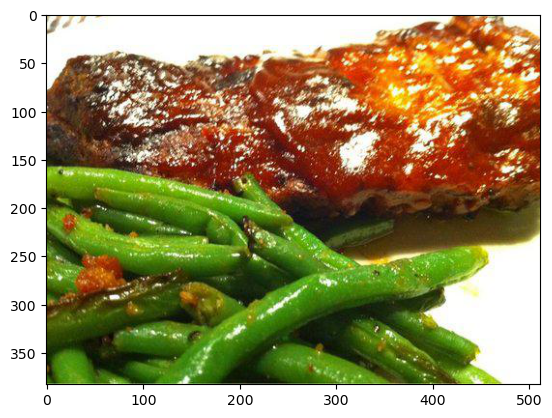

In [26]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Load a test image
img_path = '82439.jpg'
img = Image.open(img_path).convert('RGB')
plt.imshow(img)

In [27]:
# Resize image and convert to tensor
transform = transforms.Compose([transforms.Resize(IMG_SIZE), transforms.ToTensor()])
img = transform(img)
img = img.unsqueeze(0)

In [28]:
# Get model predictions
model.eval()
with torch.no_grad():
    sl_preds, ml_preds = model(img.to(device))

sl_preds = torch.nn.functional.softmax(sl_preds)
sl_preds = sl_preds.cpu().numpy()
ml_preds = ml_preds.cpu().numpy()

C:\Users\danie\AppData\Local\Temp\ipykernel_34200\2002643617.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sl_preds = torch.nn.functional.softmax(sl_preds)


Text(0, 0.5, 'Probability')

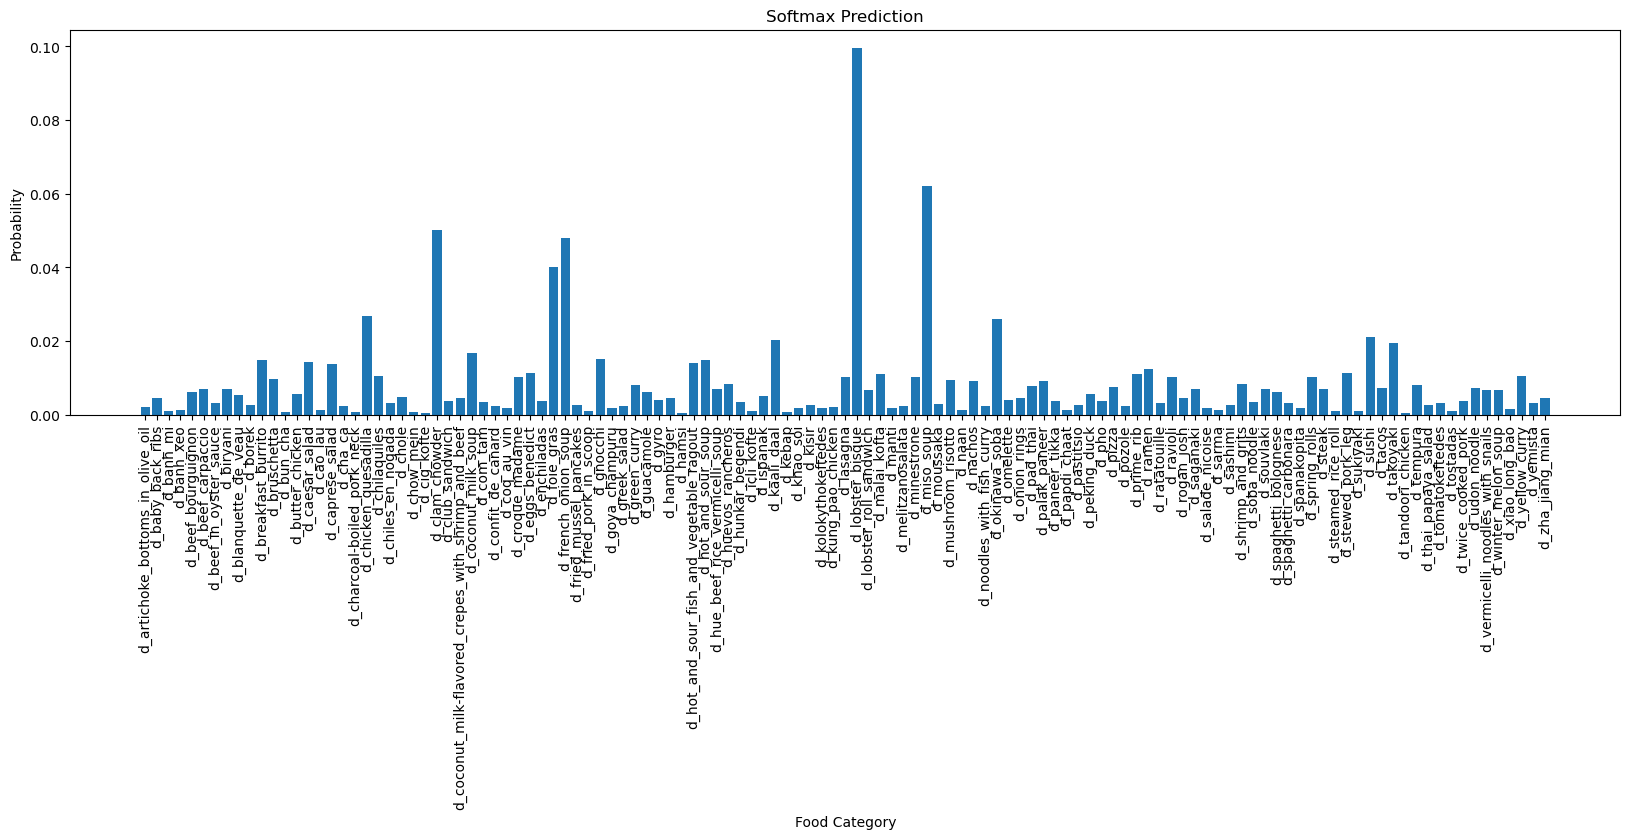

In [29]:
# Plot prediction results
sl_preds = sl_preds.squeeze()
plt.figure(figsize=(20, 5))
plt.bar(classes, sl_preds)
plt.title('Softmax Prediction')
plt.xticks(rotation=90)
plt.xlabel('Food Category')
plt.ylabel('Probability')
#plt.show()
#plt.savefig("sl_result.jpg")

Text(0, 0.5, 'Probability')

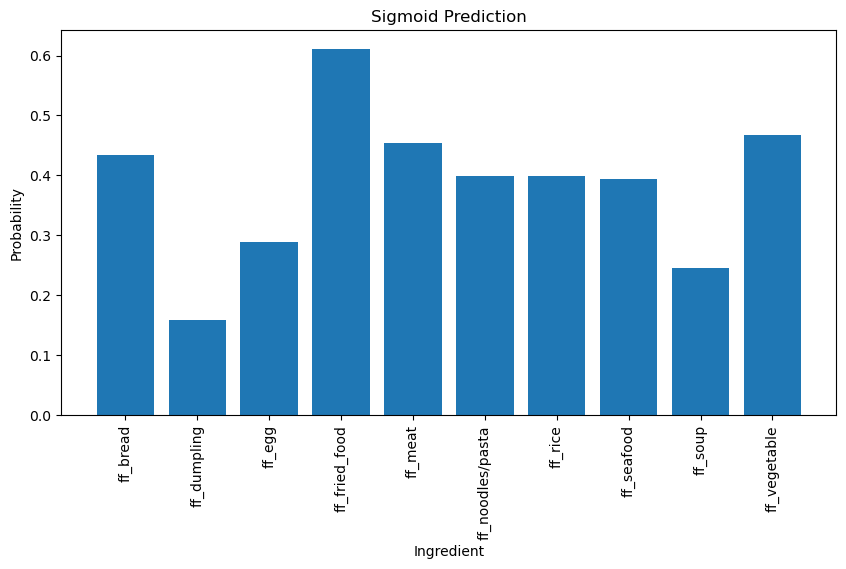

In [30]:
ml_preds = ml_preds.squeeze()
plt.figure(figsize=(10, 5))
plt.bar(base_ing, ml_preds)
plt.title('Sigmoid Prediction')
plt.xticks(rotation=90)
plt.xlabel('Ingredient')
plt.ylabel('Probability')
#plt.show()
#plt.savefig("ml_result.jpg")

###                                 -------------------------- GNN -------------------------------

In [32]:
import torch.nn as nn

class IGRL(nn.Module):
    def __init__(self, ml_preds, sl_preds):
        super(IGRL, self).__init__()

        self.visual_attention = nn.Linear(ml_preds, 1)
        self.feature_map_projection = nn.Linear(ml_preds, ml_preds)
        self.gcn = GCN(ml_preds)
        self.classifier = nn.Linear(ml_preds + sl_preds, sl_preds)

    def forward(self, visual_features, semantic_features):
        # Visual node representation
        visual_attentions = self.visual_attention(visual_features)
        visual_representations = visual_features * visual_attentions
        visual_representations = self.feature_map_projection(visual_representations)

        # Graph convolutional network
        gcn_output = self.gcn(visual_representations, semantic_features)

        # Fusion and classification
        fusion_input = torch.cat((gcn_output, semantic_features), dim=1)
        output = self.classifier(fusion_input)

        return output

class GCN(nn.Module):
    def __init__(self, num_nodes):
        super(GCN, self).__init__()

        self.graph_convolution = nn.Linear(num_nodes, num_nodes)

    def forward(self, visual_representations, semantic_features):
        # Graph convolution
        gcn_output = self.graph_convolution(visual_representations)

        # Fusion with semantic features
        fused_output = gcn_output + semantic_features

        return fused_output

    # Definir datos de entrada de ejemplo
ml_preds = 10  # Número de predicciones de aprendizaje automático
sl_preds = 10  # Número de predicciones de aprendizaje supervisado
visual_features = torch.randn(1, ml_preds)  # Características visuales de ejemplo
semantic_features = torch.randn(1, sl_preds)  # Características semánticas de ejemplo

# Crear una instancia del modelo IGRL
model = IGRL(ml_preds, sl_preds)

# Pasar los datos de entrada por el modelo
output = model(visual_features, semantic_features)

# Mostrar los resultados
print("Salida del modelo:")
print(output)


Salida del modelo:
tensor([[-0.0803,  0.6324, -1.2084,  0.4928,  0.1410,  0.4140,  0.3399, -0.2952,
          0.5171, -0.4179]], grad_fn=<AddmmBackward0>)


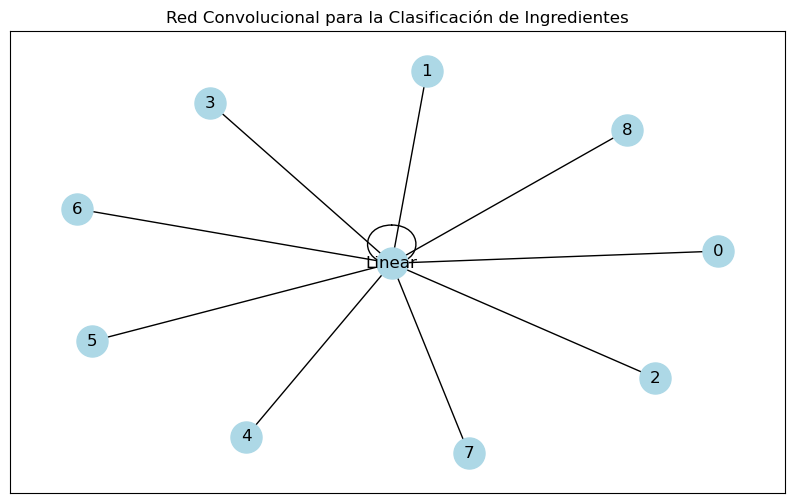

In [41]:
import networkx as nx
import matplotlib.pyplot as plt

hidden_layers = [layer for layer in model.modules() if isinstance(layer, nn.Linear)][:-1] # Obtener todas las capas excepto la última capa lineal

ingredient_classes = df_train.columns[:-3]  # Obtener las clases de ingredientes

# Crear un grafo vacío
graph = nx.Graph()

# Agregar nodos para las capas ocultas
for i, layer in enumerate(hidden_layers):
    graph.add_node(layer.__class__.__name__, layer=i)

# Agregar nodos para las clases de ingredientes
for i, ingredient_class in enumerate(ingredient_classes):
    graph.add_node(ingredient_class, layer=len(hidden_layers)+1)

# Agregar bordes entre las capas ocultas
for i in range(len(hidden_layers) - 1):
    graph.add_edge(hidden_layers[i].__class__.__name__, hidden_layers[i+1].__class__.__name__)

# Agregar bordes entre las capas ocultas y las clases de ingredientes
for layer in hidden_layers:
    for ingredient_class in ingredient_classes:
        graph.add_edge(layer.__class__.__name__, ingredient_class)

        # Configurar la posición de los nodos en el grafo
pos = nx.spring_layout(graph)

# Dibujar el grafo
plt.figure(figsize=(10, 6))
nx.draw_networkx(graph, pos=pos, with_labels=True, node_size=500, node_color='lightblue')
plt.title('Red Convolucional para la Clasificación de Ingredientes')
plt.show()

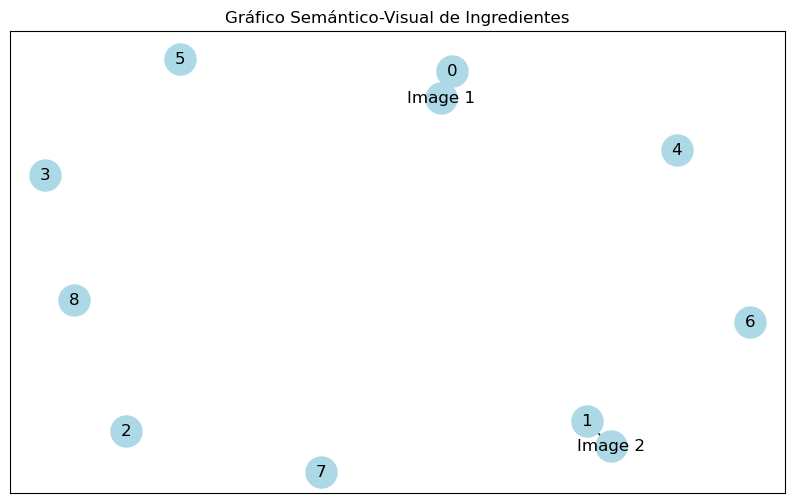

In [52]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Obtener las predicciones de los ingredientes clasificados
#predictions = np.concatenate(([sl_preds], [ml_preds]), axis=1)
predictions = np.array([[sl_preds, ml_preds]])


# Crear un grafo vacío para el gráfico semántico-visual
semantic_visual_graph = nx.Graph()

# Agregar nodos para las clases de ingredientes
for i, ingredient_class in enumerate(ingredient_classes):
    semantic_visual_graph.add_node(ingredient_class, layer='Semantic')

# Agregar nodos para las imágenes y sus ingredientes clasificados
for i, prediction in enumerate(predictions[0]):
    if prediction > 0.5:
        image_node = f'Image {i+1}'
        semantic_visual_graph.add_node(image_node, layer='Visual')
        semantic_visual_graph.add_edge(ingredient_classes[i], image_node)

# Visualizar el gráfico semántico-visual
plt.figure(figsize=(10, 6))
pos_semantic = nx.spring_layout(semantic_visual_graph, seed=42)
nx.draw_networkx(semantic_visual_graph, pos=pos_semantic, with_labels=True, node_size=500, node_color='lightblue')
plt.title('Gráfico Semántico-Visual de Ingredientes')
plt.show()